In [174]:
%matplotlib inline
import plotly.graph_objects as go
import numpy as np
from scipy.sparse import load_npz
from tqdm import tqdm


## Dataset

In [1]:
from datasets import load_dataset
# Load the dataset
ds = load_dataset("ccdv/arxiv-classification", "no_ref")

# Basic statistics
print("Splits:", ds.keys())
print("Train size:", len(ds["train"]))
print("Test size:", len(ds["test"]))
print("Features:", ds["train"].features)
print("Example record:", ds["train"][0])

# Dictionary mapping from numeric labels to class names
arxiv_subjects = {
    '0': 'Commutative Algebra',
    '1': 'Computer Vision',
    '2': 'Artificial Intelligence',
    '3': 'Systems and Control',
    '4': 'Group Theory',
    '5': 'Computational Engineering',
    '6': 'Programming Languages',
    '7': 'Information Theory',
    '8': 'Data Structures',
    '9': 'Neural and Evolutionary',
    '10': 'Statistics Theory'
}

Splits: dict_keys(['train', 'validation', 'test'])
Train size: 28388
Test size: 2500
Features: {'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['math.AC', 'cs.CV', 'cs.AI', 'cs.SY', 'math.GR', 'cs.CE', 'cs.PL', 'cs.IT', 'cs.DS', 'cs.NE', 'math.ST'], id=None)}
Example record: {'text': 'Constrained Submodular Maximization via a\nNon-symmetric Technique\n\narXiv:1611.03253v1 [] 10 Nov 2016\n\nNiv Buchbinder∗\n\nMoran Feldman†\n\nNovember 11, 2016\n\nAbstract\nThe study of combinatorial optimization problems with a submodular objective has attracted\nmuch attention in recent years. Such problems are important in both theory and practice because\ntheir objective functions are very general. Obtaining further improvements for many submodular\nmaximization problems boils down to finding better algorithms for optimizing a relaxation of\nthem known as the multilinear extension.\nIn this work we present an algorithm for optimizing the multilinear relaxation whose guarantee impr

# TF IDF

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

def size_mb(docs):
    return sum(len(s.encode("utf-8")) for s in docs) / 1e6

data_train = ds["train"][:]['text']

data_train_size_mb = size_mb(data_train)
print(f"Size of the data set: {data_train_size_mb:.2f} MB")

vectorizer = TfidfVectorizer(
        sublinear_tf=True, max_df=0.5, min_df=20, stop_words="english", token_pattern=r'\b[a-zA-Z]{2,}\b'
    )
tfidf_matrix_train = vectorizer.fit_transform(data_train)
print(f"Number of features: {tfidf_matrix_train.shape[1]}")

feature_names = vectorizer.get_feature_names_out()


##### Load the test set
data_test = ds["test"][:]['text']

tfidf_matrix_test = vectorizer.transform(data_test)
print(f"Number of features: {tfidf_matrix_test.shape[1]}")

Size of the data set: 1650.25 MB
Number of features: 53085
Number of features: 53085


In [12]:
from scipy.sparse import save_npz

# Save the tfidf_matrix to a file
save_npz("TF-IDF embeddings/tfidf_matrix_train.npz", tfidf_matrix_train)

# Save the feature names to a file
with open("TF-IDF embeddings/feature_names.txt", "w") as f:
    for name in feature_names:
        f.write(f"{name}\n")

print("TF-IDF matrix saved successfully!")

# same for the test set
save_npz("TF-IDF embeddings/tfidf_matrix_test.npz", tfidf_matrix_test)
# Save the feature names to a file


TF-IDF matrix saved successfully!


In [ ]:
try:
    tfidf_matrix_train
except NameError:
    print("TF-IDF matrix is not loaded. Loading now...")
    tfidf_matrix_train = load_npz("TF-IDF embeddings/tfidf_matrix.npz")
    with open("TF-IDF embeddings/feature_names.txt", "r") as f:
        feature_names = [line.strip() for line in f.readlines()]

TF-IDF matrix is not loaded. Loading now...


In [ ]:
tfidf_matrix_train.shape

# Word2Vec vectors

In [44]:
import gensim.downloader as api
import logging
import os
import gensim

# Set up logging to display information
logging.basicConfig(level=logging.INFO)

# Define the model name
model_name = 'word2vec-google-news-300'

if os.path.isfile("models/word2vec-google-news-300.model"):
    print("Model already exists, loading from file...")
    # Load the model from the file
    wv = gensim.models.KeyedVectors.load("models/word2vec-google-news-300.model")
else:
    # Attempt to load the model
    try:
        print(f"\nAttempting to download '{model_name}' using gensim downloader...")
        # Load the model using gensim's downloader
        wv = api.load(model_name)
        print("\nModel downloaded/loaded successfully!")
        print(f"It is now cached in: {api.BASE_DIR}")

        # Save the Word2Vec model
        if wv:
            model_path = "models/word2vec.model"
            print(f"Saving the Word2Vec model to '{model_path}'...")
            wv.save(model_path)
            print("Model saved successfully!")
        else:
            print("Word2Vec model is not loaded, so it cannot be saved.")

    except Exception as e:
        print(f"\nFailed to download or load using gensim downloader: {e}")
        wv = None  # Ensure wv is defined even if loading fails

# Check if the model was loaded successfully
if wv:
    print("Word2Vec model is ready to use.")
else:
    print("Word2Vec model could not be loaded.")

INFO:gensim.utils:loading KeyedVectors object from models/word2vec-google-news-300.model


Model already exists, loading from file...


INFO:gensim.utils:loading vectors from models/word2vec-google-news-300.model.vectors.npy with mmap=None
INFO:gensim.utils:KeyedVectors lifecycle event {'fname': 'models/word2vec-google-news-300.model', 'datetime': '2025-05-11T16:47:10.156556', 'gensim': '4.3.3', 'python': '3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.26100-SP0', 'event': 'loaded'}


Word2Vec model is ready to use.


In [54]:
# Load TF-IDF matrix and feature names if not already loaded
try:
    tfidf_matrix_train
except NameError:
    print("TF-IDF matrix is not loaded. Loading now...")
    tfidf_matrix_train = load_npz("TF-IDF embeddings/tfidf_matrix.npz")
    with open("TF-IDF embeddings/feature_names.txt", "r") as f:
        feature_names = [line.strip() for line in f.readlines()]

# Initialize Word2Vec embedding matrix
word2vec_embedding = np.zeros((tfidf_matrix_train.shape[0], 300))

# Load dataset
print("Loading dataset...")
texts = ds["train"][:]['text']
print("Dataset loaded successfully!")

# Preprocess texts
print("Preprocessing texts...")
tokenized_texts = [text.split() for text in texts]
filtered_texts = [[word for word in text if word in wv.key_to_index] 
                 for text in tokenized_texts]
print("Text preprocessing completed!")

# Precompute feature index map
feature_index = {word: idx for idx, word in enumerate(feature_names)}

# Precompute word vector cache
print("Caching word vectors...")
word_vector_cache = {word: wv[word] for word in wv.key_to_index}

# Precompute TF-IDF dictionaries for each document
print("Preprocessing TF-IDF weights...")
from scipy.sparse import coo_matrix

tfidf_dicts = []
for i in tqdm(range(tfidf_matrix_train.shape[0]), desc="Creating TF-IDF dictionaries"):
    row = tfidf_matrix_train[i].tocoo()
    words_in_doc = [feature_names[idx] for idx in row.col]
    tfidf_dicts.append(dict(zip(words_in_doc, row.data)))

# Main processing loop
print("Calculating weighted embeddings...")
for i, words in enumerate(tqdm(filtered_texts, desc="Processing documents")):
    if not words:
        continue  # Keep as zeros if no valid words
    
    # Get vectors and weights
    vectors = np.stack([word_vector_cache[word] for word in words])
    weights = np.array([tfidf_dicts[i].get(word, 0.0) for word in words])
    
    # Calculate weighted average with numerical stability
    adjusted_weights = weights + 1e-10
    try:
        weighted_avg = np.average(vectors, axis=0, weights=adjusted_weights)
    except ZeroDivisionError:
        weighted_avg = np.mean(vectors, axis=0)
    
    word2vec_embedding[i] = weighted_avg

# Save results
print("Saving embeddings...")
np.savez_compressed("Word2Vec embeddings/word2vec_embedding.npz", 
                   word2vec_embedding=word2vec_embedding)
print("Embeddings saved successfully!")

Loading dataset...
Dataset loaded successfully!
Preprocessing texts...
Text preprocessing completed!
Caching word vectors...
Preprocessing TF-IDF weights...


Creating TF-IDF dictionaries: 100%|██████████| 28388/28388 [00:20<00:00, 1357.30it/s]


Calculating weighted embeddings...


Processing documents: 100%|██████████| 28388/28388 [16:29<00:00, 28.70it/s]  


Saving embeddings...
Embeddings saved successfully!


In [45]:
# Load TF-IDF matrix and feature names if not already loaded
try:
    tfidf_matrix_test
except NameError:
    print("TF-IDF matrix is not loaded. Loading now...")
    tfidf_matrix_test = load_npz("TF-IDF embeddings/tfidf_matrix.npz")
    with open("TF-IDF embeddings/feature_names.txt", "r") as f:
        feature_names = [line.strip() for line in f.readlines()]

# Initialize Word2Vec embedding matrix
word2vec_embedding_test = np.zeros((tfidf_matrix_test.shape[0], 300))

# Load dataset
print("Loading dataset...")
texts = ds["test"][:]['text']
print("Dataset loaded successfully!")

# Preprocess texts
print("Preprocessing texts...")
tokenized_texts = [text.split() for text in texts]
filtered_texts = [[word for word in text if word in wv.key_to_index] 
                 for text in tokenized_texts]
print("Text preprocessing completed!")

# Precompute feature index map
feature_index = {word: idx for idx, word in enumerate(feature_names)}

# Precompute word vector cache
print("Caching word vectors...")
word_vector_cache = {word: wv[word] for word in wv.key_to_index}

# Precompute TF-IDF dictionaries for each document
print("Preprocessing TF-IDF weights...")
from scipy.sparse import coo_matrix

tfidf_dicts = []
for i in tqdm(range(tfidf_matrix_test.shape[0]), desc="Creating TF-IDF dictionaries"):
    row = tfidf_matrix_test[i].tocoo()
    words_in_doc = [feature_names[idx] for idx in row.col]
    tfidf_dicts.append(dict(zip(words_in_doc, row.data)))

# Main processing loop
print("Calculating weighted embeddings...")
for i, words in enumerate(tqdm(filtered_texts, desc="Processing documents")):
    if not words:
        continue  # Keep as zeros if no valid words
    
    # Get vectors and weights
    vectors = np.stack([word_vector_cache[word] for word in words])
    weights = np.array([tfidf_dicts[i].get(word, 0.0) for word in words])
    
    # Calculate weighted average with numerical stability
    adjusted_weights = weights + 1e-10
    try:
        weighted_avg = np.average(vectors, axis=0, weights=adjusted_weights)
    except ZeroDivisionError:
        weighted_avg = np.mean(vectors, axis=0)
    
    word2vec_embedding_test[i] = weighted_avg

# Save results
print("Saving embeddings...")
np.savez_compressed("Word2Vec embeddings/word2vec_embedding_test.npz", 
                   word2vec_embedding_test=word2vec_embedding_test)
print("Embeddings saved successfully!")

Loading dataset...
Dataset loaded successfully!
Preprocessing texts...
Text preprocessing completed!
Caching word vectors...
Preprocessing TF-IDF weights...


Creating TF-IDF dictionaries: 100%|██████████| 2500/2500 [00:01<00:00, 2165.66it/s]


Calculating weighted embeddings...


Processing documents: 100%|██████████| 2500/2500 [00:38<00:00, 64.75it/s]


Saving embeddings...


NameError: name 'word2vec_embedding' is not defined

In [4]:
# Load the Word2Vec embeddings
word2vec_embeddings = np.load("Word2Vec embeddings/word2vec_embedding.npz")["word2vec_embedding"]
print(f"Word2Vec embeddings shape: {word2vec_embeddings.shape}")

Word2Vec embeddings shape: (28388, 300)


In [13]:
from sklearn.decomposition import PCA

# Assuming `data` is your 300-dimensional dataset (shape: [n_samples, 300])
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(word2vec_embeddings[:10000])




colors = np.array(ds["train"][:]['label'])[:10000]
# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_data[:, 0],
    y=reduced_data[:, 1],
    z=reduced_data[:, 2],
    mode='markers+text',
    marker=dict(
        size=5,
        color=colors,
        colorscale='Plasma',
        opacity=0.8
    ),
    # text=titles[:200],
)])

fig.update_layout(
    # title=f"3D Scatter Plot of Word Vectors for '{center_word}'",
    scene=dict(
        xaxis_title='PCA 1',
        yaxis_title='PCA 2',
        zaxis_title='PCA 3'
    ),
    coloraxis_colorbar=dict(
        title="Similarity",
        thickness=20,
        len=0.75,
        x=1.1  # Position the colorbar slightly outside the plot
    ),
    width=1000,
    height=800,
)
fig.show(renderer="browser")


In [ ]:
try:
    tfidf_matrix_train
except NameError:
    print("TF-IDF matrix is not loaded. Loading now...")
    tfidf_matrix_train = load_npz("TF-IDF embeddings/tfidf_matrix.npz")
    with open("TF-IDF embeddings/feature_names.txt", "r") as f:
        feature_names = [line.strip() for line in f.readlines()]

word2vec_embedding = np.zeros((tfidf_matrix_train.shape[0], 300))

texts = ds["train"][:]['text']

# Tokenize and filter words in the vocabulary
tokenized_texts = [text.split() for text in texts]
filtered_texts = [[word for word in text if word in wv.key_to_index] for text in tokenized_texts]

# Create a mapping of feature names to indices
feature_index = {word: idx for idx, word in enumerate(feature_names)}

# Vectorize the process
for i, text in enumerate(tqdm(filtered_texts, desc="Processing texts")):
    if text:  # Ensure the text is not empty after filtering
        word_vectors = np.stack([wv[word] for word in text])
        tfidf_weights = np.array([tfidf_matrix_train[i, feature_index.get(word, 0)] for word in text]).flatten()
        weighted_average_vector = np.average(word_vectors, axis=0, weights=tfidf_weights)
        word2vec_embedding[i] = weighted_average_vector

In [ ]:
# === 1. Get Closest Words (Most Similar Vectors) ===
try:
    print("\n--- Finding words closest to 'computer' ---")
    similar_words = wv.most_similar('computer', topn=10)

    print("Words most similar to 'computer':")
    for word, score in similar_words:
        print(f"- {word} (Similarity: {score:.4f})")

except NameError:
    print("Error: The 'wv' object is not loaded.")
except KeyError as e:
    print(f"Error: Word '{e}' not found in the vocabulary for similarity check.")
except Exception as e:
    print(f"An error occurred: {e}")

# === 2. Access a Specific Word's Vector ===
try:
    print("\n--- Accessing the vector for 'tree' ---")
    vector_tree = wv['tree']

    print(f"Successfully retrieved vector for 'tree'.")
    print(f"Vector dimensions (shape): {vector_tree.shape}")

except NameError:
    print("Error: The 'wv' object is not loaded.")
except KeyError as e:
    print(f"Error: Word '{e}' not found in the vocabulary.")
except Exception as e:
    print(f"An error occurred: {e}")

# Bert embedding

In [12]:
from transformers import BertTokenizer, BertModel
import torch

documents = ds["train"][:100]['text']

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Tokenize the input text
inputs = tokenizer(documents, return_tensors='pt', padding=True, truncation=True)
# Get the embeddings
with torch.no_grad():
    outputs = model(**inputs)
    # The last hidden state is the first element of the output tuple
    last_hidden_states = outputs.last_hidden_state
    # Extract the embedding for the [CLS] token (first token)
    cls_embedding = last_hidden_states[:, 0, :]

KeyboardInterrupt: 

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

documents = ds["train"][:100]['text']

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=11)

# Tokenize and encode the documents
inputs = tokenizer(documents, add_special_tokens=True, max_length=512, truncation=True, padding=True, return_tensors="pt")

outputs = model(**inputs)
logits = outputs.logits

probs = torch.softmax(logits, dim=1)  # Convert logits to probabilities
predicted_class = torch.argmax(probs, dim=1)  # Class with highest probability

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
predicted_class

tensor([2, 2, 2, 2, 2, 2, 2, 2, 6, 6])

# Classifying based on embeddings

## Training set-up

### Set up the Dataset class for the dataloaders

In [68]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc
from matplotlib.gridspec import GridSpec
import plotly.graph_objects as go
from scipy.sparse import load_npz
from tqdm import tqdm


In [48]:
# set up the class for the datasets
class ArxivDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if isinstance(self.data[idx], np.ndarray):
            x = torch.tensor(self.data[idx], dtype=torch.float32)
        else:
            x = torch.tensor(self.data[idx].toarray(), dtype=torch.float32)
            x = x.view(-1)
        y = self.labels[idx].detach().clone().to(torch.float32) if isinstance(self.labels[idx], torch.Tensor) else torch.tensor(self.labels[idx], dtype=torch.float32)
        return x, y

### Set up the models

In [49]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, 11)

    def forward(self,x):
        x = self.linear(x)
        # x = torch.softmax(x, dim=0)
        return (x)

In [50]:
class NN(torch.nn.Module):
    def __init__(self, input_dim):
        super(NN, self).__init__()
        self.linear1 = torch.nn.Linear(input_dim, 50)
        self.linear2 = torch.nn.Linear(50, 11)


    def forward(self,x):
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        # x = torch.softmax(x, dim=0)
        return (x)

### One hot encode the labels

In [ ]:
# Number of classes (based on your `arxiv_subjects` dictionary, there are 11 classes)
num_classes = len(arxiv_subjects)

# One-hot encode the labels
one_hot_labels_train = torch.nn.functional.one_hot(torch.from_numpy(np.array(ds["train"][:]['label'])).to(torch.long), num_classes=num_classes)
one_hot_labels_test = torch.nn.functional.one_hot(torch.from_numpy(np.array(ds["test"][:]['label'])).to(torch.long), num_classes=num_classes)

### Set up the training and testing functions

In [227]:
def train(network, epochs, data_train, data_test, labels_train, labels_test, log_interval=10, lr = 0.001, batch_size_train=64):
    # we now select the device based on what is available
    if torch.cuda.is_available():
        DEVICE = torch.device('cuda')
    else:
        DEVICE = torch.device('cpu')

    network.to(DEVICE)    
        
    # Load the dataset
    train_dataset = ArxivDataset(data_train, labels_train)
    test_dataset = ArxivDataset(data_test, labels_test)

    batch_size_test = data_test.shape[0]  # by default we use the whole test set for testing.

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=True)

    optimizer = torch.optim.Adam(network.parameters(), lr=lr)
    network.train()
    results = {
            "train_accuracy": [],
            "train_loss": [],
            "test_accuracy": [],
            "test_loss": [],
            "train_counter": [],
            "test_counter": [],
            "test_output": [],
            "test_target": []
    }
    
    # Test the model (logging is set up for a single batch in the test set, this might cause problems later)
    network.eval()
    with torch.no_grad():
        test_loss = 0
        for data, target in test_loader:
            data = data.to(DEVICE)
            target = target.to(DEVICE)
            output = network(data)
            # print('output: ', output.shape, 'target: ', target.shape)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()

            results["test_loss"].append(test_loss/len(data))
            results["test_accuracy"].append((output.argmax(dim=1) == target.argmax(dim=1)).float().mean().item())
            results["test_counter"].append(
                len(test_loader.dataset))
            results["test_output"].append(torch.softmax(output.cpu().detach(), dim=1).numpy())
            results["test_target"].append(target.cpu().detach().numpy())

    for epoch in range(1, epochs + 1):
        network.train()
        train_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            data = data.to(DEVICE)
            target = target.to(DEVICE)
            output = network(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), train_loss/log_interval))
                train_loss = 0
                
                results["train_loss"].append(loss.item())
                results["train_accuracy"].append((output.argmax(dim=1) == target.argmax(dim=1)).float().mean().item())
                results["train_counter"].append(
                    (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

        # Test the model (logging is set up for a single batch in the test set, this might cause problems later)
        network.eval()
        with torch.no_grad():
            test_loss = 0
            for data, target in test_loader:
                data = data.to(DEVICE)
                target = target.to(DEVICE)
                output = network(data)
                # print('output: ', output.shape, 'target: ', target.shape)
                test_loss += F.cross_entropy(output, target, reduction='sum').item()

                results["test_loss"].append(test_loss/len(data))
                results["test_accuracy"].append((output.argmax(dim=1) == target.argmax(dim=1)).float().mean().item())
                results["test_counter"].append(
                    (batch_idx*64) + ((epoch-1)*len(test_loader.dataset)))
                results["test_output"].append(torch.softmax(output.cpu().detach(), dim=1).numpy())
                results["test_target"].append(target.cpu().detach().numpy())

    return results


### Set up the results plotting

In [229]:
def plot_results(results, class_names=None):
    """
    Plots training results from the dictionary returned by train2()
    
    Args:
        results (dict): Dictionary containing training results with keys:
            - train_accuracy
            - train_loss
            - test_accuracy
            - test_loss
            - train_counter
            - test_counter
        class_names (list): List of class names for the confusion matrix
    """
    # Create figure with subplots
    plt.figure(figsize=(18, 12))
    gs = GridSpec(3, 3)
    
    # Custom color palette
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    # 1. Training Loss Plot
    ax1 = plt.subplot(gs[0, 0])
    ax1.plot(results['train_counter'], results['train_loss'], color=colors[0], label='Training Loss')
    ax1.set_title('Training Loss Over Time', fontsize=12, pad=10)
    ax1.set_xlabel('Number of training examples seen', fontsize=10)
    ax1.set_ylabel('Loss', fontsize=10)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend(fontsize=10)
    
    # 2. Test Loss Plot
    ax2 = plt.subplot(gs[0, 1])
    ax2.plot(results['test_counter'], results['test_loss'], color=colors[1], label='Test Loss')
    ax2.set_title('Test Loss Over Time', fontsize=12, pad=10)
    ax2.set_xlabel('Number of training examples seen', fontsize=10)
    ax2.set_ylabel('Loss', fontsize=10)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend(fontsize=10)
    
    # 3. Accuracy Plot
    ax3 = plt.subplot(gs[0, 2])
    ax3.plot(results['train_counter'], results['train_accuracy'], color=colors[0], label='Train Accuracy')
    ax3.plot(results['test_counter'], results['test_accuracy'], color=colors[1], label='Test Accuracy')
    ax3.set_title('Accuracy Over Time', fontsize=12, pad=10)
    ax3.set_xlabel('Number of training examples seen', fontsize=10)
    ax3.set_ylabel('Accuracy', fontsize=10)
    ax3.grid(True, linestyle='--', alpha=0.7)
    ax3.legend(fontsize=10)

    ax4 = plt.subplot(gs[1, 0])
    ax4.set_title('Confusion Matrix', fontsize=12, pad=10)
    # ax4.axis('off')
    if class_names is not None:
        cm = confusion_matrix(np.argmax(results['test_target'][-1], axis=1), 
                      np.argmax(results['test_output'][-1], axis=1))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax4,
                    xticklabels=class_names, yticklabels=class_names)
        ax4.set_xlabel('Predicted', fontsize=10)
        ax4.set_ylabel('True', fontsize=10)
    else:
        ax4.text(0.5, 0.5, 'No class names provided', ha='center', va='center', fontsize=12)

    # 5. Classification Report
    ax5 = plt.subplot(gs[1, 1])
    if class_names is not None and 'test_target' in results and 'test_output' in results:
        y_true = np.argmax(results['test_target'][-1], axis=1)
        y_pred = np.argmax(results['test_output'][-1], axis=1)
        
        # Calculate metrics
        report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
        
        # Plot precision, recall, f1 per class
        metrics = ['precision', 'recall', 'f1-score']
        x = np.arange(len(class_names))
        width = 0.25
        
        for i, metric in enumerate(metrics):
            values = [report[name][metric] for name in class_names]
            ax5.bar(x + i*width, values, width, label=metric.capitalize(), color=colors[i+2])
        
        ax5.set_title('Per-Class Metrics', fontsize=12)
        ax5.set_xticks(x + width)
        ax5.set_xticklabels(class_names, rotation=45, ha="right", fontsize=8)
        ax5.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize=10)
        ax5.grid(True, linestyle='--', alpha=0.3, axis='y')
        
        # 6. Macro Metrics
        ax6 = plt.subplot(gs[1, 2])
        macro_metrics = {
            'Precision': report['macro avg']['precision'],
            'Recall': report['macro avg']['recall'],
            'F1-score': report['macro avg']['f1-score'],
            'Accuracy': report['accuracy']
        }
        ax6.bar(macro_metrics.keys(), macro_metrics.values(), color=colors[:4])
        ax6.set_title('Macro-Averaged Metrics', fontsize=12)
        ax6.set_ylim(0, 1.1)
        for i, v in enumerate(macro_metrics.values()):
            ax6.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=10)
    else:
        ax5.text(0.5, 0.5, 'No class names provided', ha='center', va='center', fontsize=12)
        ax6 = plt.subplot(gs[1, 2])
        ax6.text(0.5, 0.5, 'No class names provided', ha='center', va='center', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Print comprehensive classification report
    if class_names is not None and 'test_target' in results and 'test_output' in results:
        print("\nDetailed Classification Report:")
        print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Print final metrics
    print("\nFinal Training Accuracy: {:.2f}%".format(results['train_accuracy'][-1] * 100))
    print("Final Test Accuracy: {:.2f}%".format(results['test_accuracy'][-1] * 100))
    print("Final Training Loss: {:.4f}".format(results['train_loss'][-1]))
    print("Final Test Loss: {:.4f}".format(results['test_loss'][-1]))

## TF IDF

### Load TF-IDF matrix and feature names if not already loaded


In [111]:
try:
    tfidf_matrix_train
except NameError:
    print("TF-IDF matrix is not loaded. Loading now...")
    tfidf_matrix_train = load_npz("TF-IDF embeddings/tfidf_matrix.npz")
    with open("TF-IDF embeddings/feature_names.txt", "r") as f:
        feature_names = [line.strip() for line in f.readlines()]

# load test set
try:
    tfidf_matrix_test
except NameError:
    print("TF-IDF matrix is not loaded. Loading now...")
    tfidf_matrix_test = load_npz("TF-IDF embeddings/tfidf_matrix_test.npz")

# print the shapes
print("TF-IDF matrix train shape:", tfidf_matrix_train.shape)
print("TF-IDF matrix test shape:", tfidf_matrix_test.shape)

TF-IDF matrix train shape: (28388, 53085)
TF-IDF matrix test shape: (2500, 53085)


### Linear Regression

In [228]:
network_TFIDF = LogisticRegression(tfidf_matrix_test[:].shape[1])  # We move the network to the GPU

results_TFIDF = train(
    network_TFIDF,
    epochs=3,
    data_train=tfidf_matrix_train,
    data_test=tfidf_matrix_test,
    labels_train=one_hot_labels_train,
    labels_test=one_hot_labels_test,
    log_interval=10,
    lr=0.001
)

Train Epoch: 1 [0/28388 (0%)]	Loss: 0.239777
Train Epoch: 1 [640/28388 (2%)]	Loss: 2.363411
Train Epoch: 1 [1280/28388 (5%)]	Loss: 2.303259
Train Epoch: 1 [1920/28388 (7%)]	Loss: 2.243628
Train Epoch: 1 [2560/28388 (9%)]	Loss: 2.183316
Train Epoch: 1 [3200/28388 (11%)]	Loss: 2.123451
Train Epoch: 1 [3840/28388 (14%)]	Loss: 2.059927
Train Epoch: 1 [4480/28388 (16%)]	Loss: 2.020061
Train Epoch: 1 [5120/28388 (18%)]	Loss: 1.969344
Train Epoch: 1 [5760/28388 (20%)]	Loss: 1.926287
Train Epoch: 1 [6400/28388 (23%)]	Loss: 1.888793
Train Epoch: 1 [7040/28388 (25%)]	Loss: 1.824236
Train Epoch: 1 [7680/28388 (27%)]	Loss: 1.779196
Train Epoch: 1 [8320/28388 (29%)]	Loss: 1.755886
Train Epoch: 1 [8960/28388 (32%)]	Loss: 1.710383
Train Epoch: 1 [9600/28388 (34%)]	Loss: 1.649620
Train Epoch: 1 [10240/28388 (36%)]	Loss: 1.613289
Train Epoch: 1 [10880/28388 (38%)]	Loss: 1.602304
Train Epoch: 1 [11520/28388 (41%)]	Loss: 1.549710
Train Epoch: 1 [12160/28388 (43%)]	Loss: 1.514099
Train Epoch: 1 [12800/283

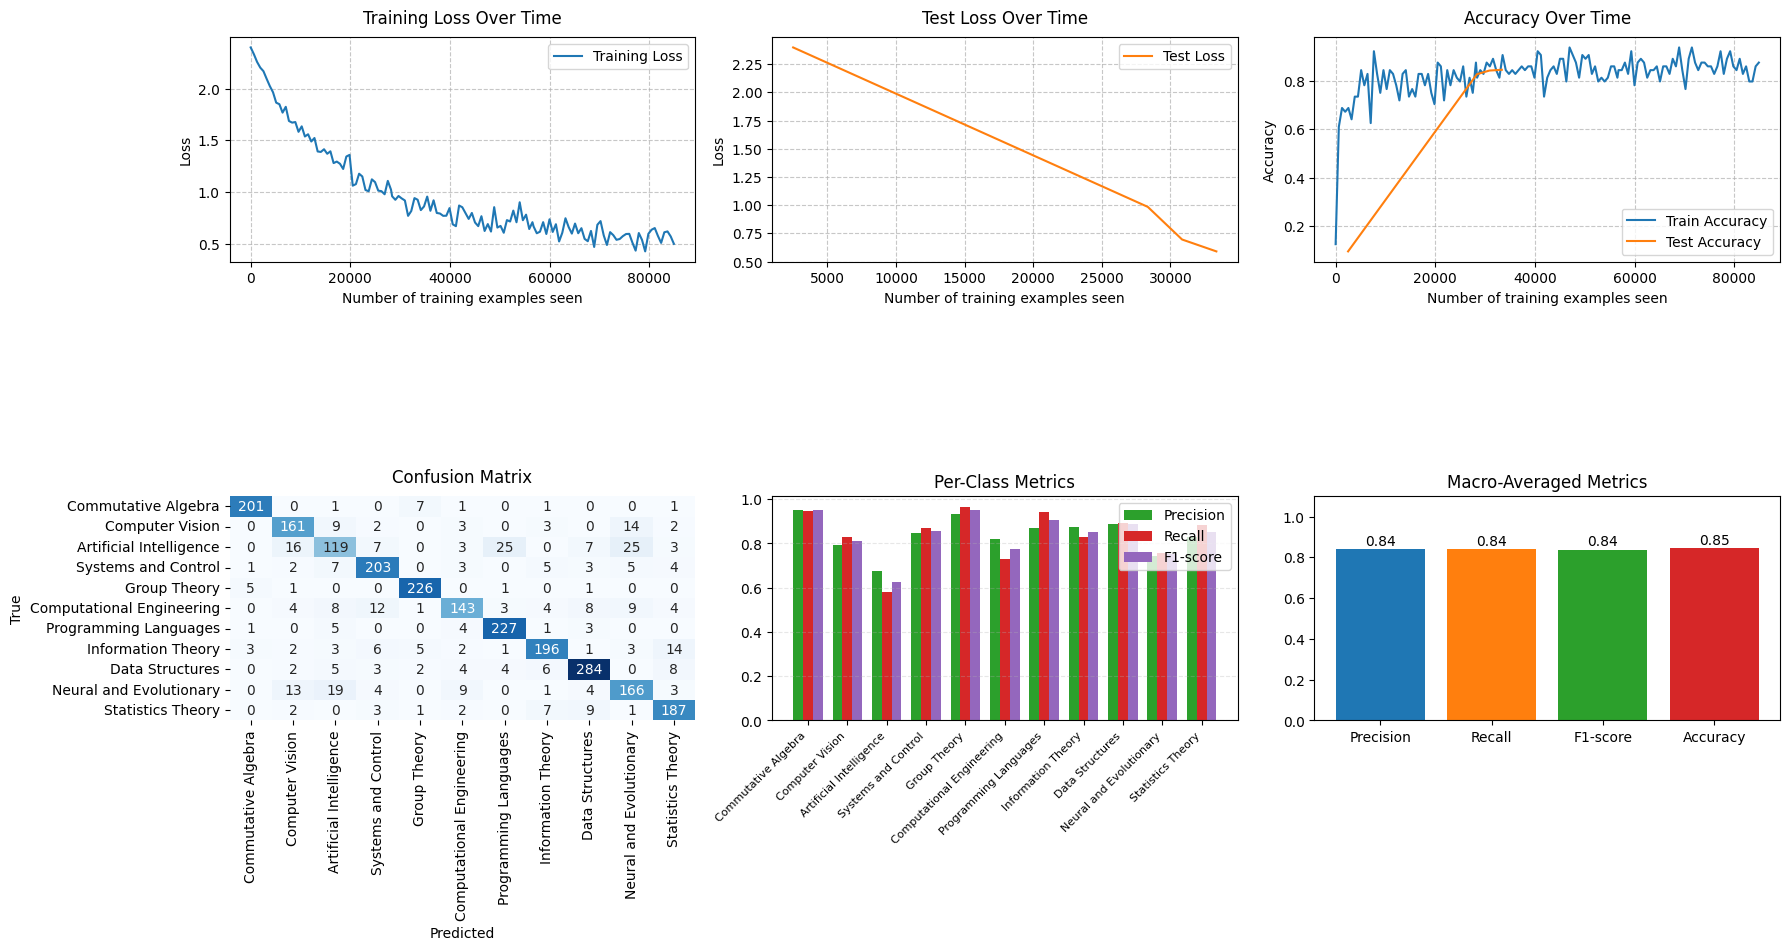


Detailed Classification Report:
                           precision    recall  f1-score   support

      Commutative Algebra       0.95      0.95      0.95       212
          Computer Vision       0.79      0.83      0.81       194
  Artificial Intelligence       0.68      0.58      0.62       205
      Systems and Control       0.85      0.87      0.86       233
             Group Theory       0.93      0.97      0.95       234
Computational Engineering       0.82      0.73      0.77       196
    Programming Languages       0.87      0.94      0.90       241
       Information Theory       0.88      0.83      0.85       236
          Data Structures       0.89      0.89      0.89       318
  Neural and Evolutionary       0.74      0.76      0.75       219
        Statistics Theory       0.83      0.88      0.85       212

                 accuracy                           0.85      2500
                macro avg       0.84      0.84      0.84      2500
             weighted avg  

In [217]:
plot_results(
	results_TFIDF,
	class_names=list(arxiv_subjects.values()),
)

### MLP

In [ ]:
network_TFIDF_NN = NN(tfidf_matrix_test[:].shape[1])
results_TFIDF_NN = train(
    network_TFIDF_NN,
    epochs=3,
    data_train=tfidf_matrix_train,
    data_test=tfidf_matrix_test,
    labels_train=one_hot_labels_train,
    labels_test=one_hot_labels_test,
    log_interval=10,
    lr=0.001
)


Train Epoch: 1 [0/28388 (0%)]	Loss: 0.241241
Train Epoch: 1 [640/28388 (2%)]	Loss: 2.372533
Train Epoch: 1 [1280/28388 (5%)]	Loss: 2.306131
Train Epoch: 1 [1920/28388 (7%)]	Loss: 2.222697
Train Epoch: 1 [2560/28388 (9%)]	Loss: 2.120495
Train Epoch: 1 [3200/28388 (11%)]	Loss: 1.983197
Train Epoch: 1 [3840/28388 (14%)]	Loss: 1.839535
Train Epoch: 1 [4480/28388 (16%)]	Loss: 1.700615
Train Epoch: 1 [5120/28388 (18%)]	Loss: 1.537942
Train Epoch: 1 [5760/28388 (20%)]	Loss: 1.418252
Train Epoch: 1 [6400/28388 (23%)]	Loss: 1.316990
Train Epoch: 1 [7040/28388 (25%)]	Loss: 1.248066
Train Epoch: 1 [7680/28388 (27%)]	Loss: 1.101490
Train Epoch: 1 [8320/28388 (29%)]	Loss: 1.066693
Train Epoch: 1 [8960/28388 (32%)]	Loss: 1.025146
Train Epoch: 1 [9600/28388 (34%)]	Loss: 0.908552
Train Epoch: 1 [10240/28388 (36%)]	Loss: 0.852145
Train Epoch: 1 [10880/28388 (38%)]	Loss: 0.833385
Train Epoch: 1 [11520/28388 (41%)]	Loss: 0.811345
Train Epoch: 1 [12160/28388 (43%)]	Loss: 0.735073
Train Epoch: 1 [12800/283

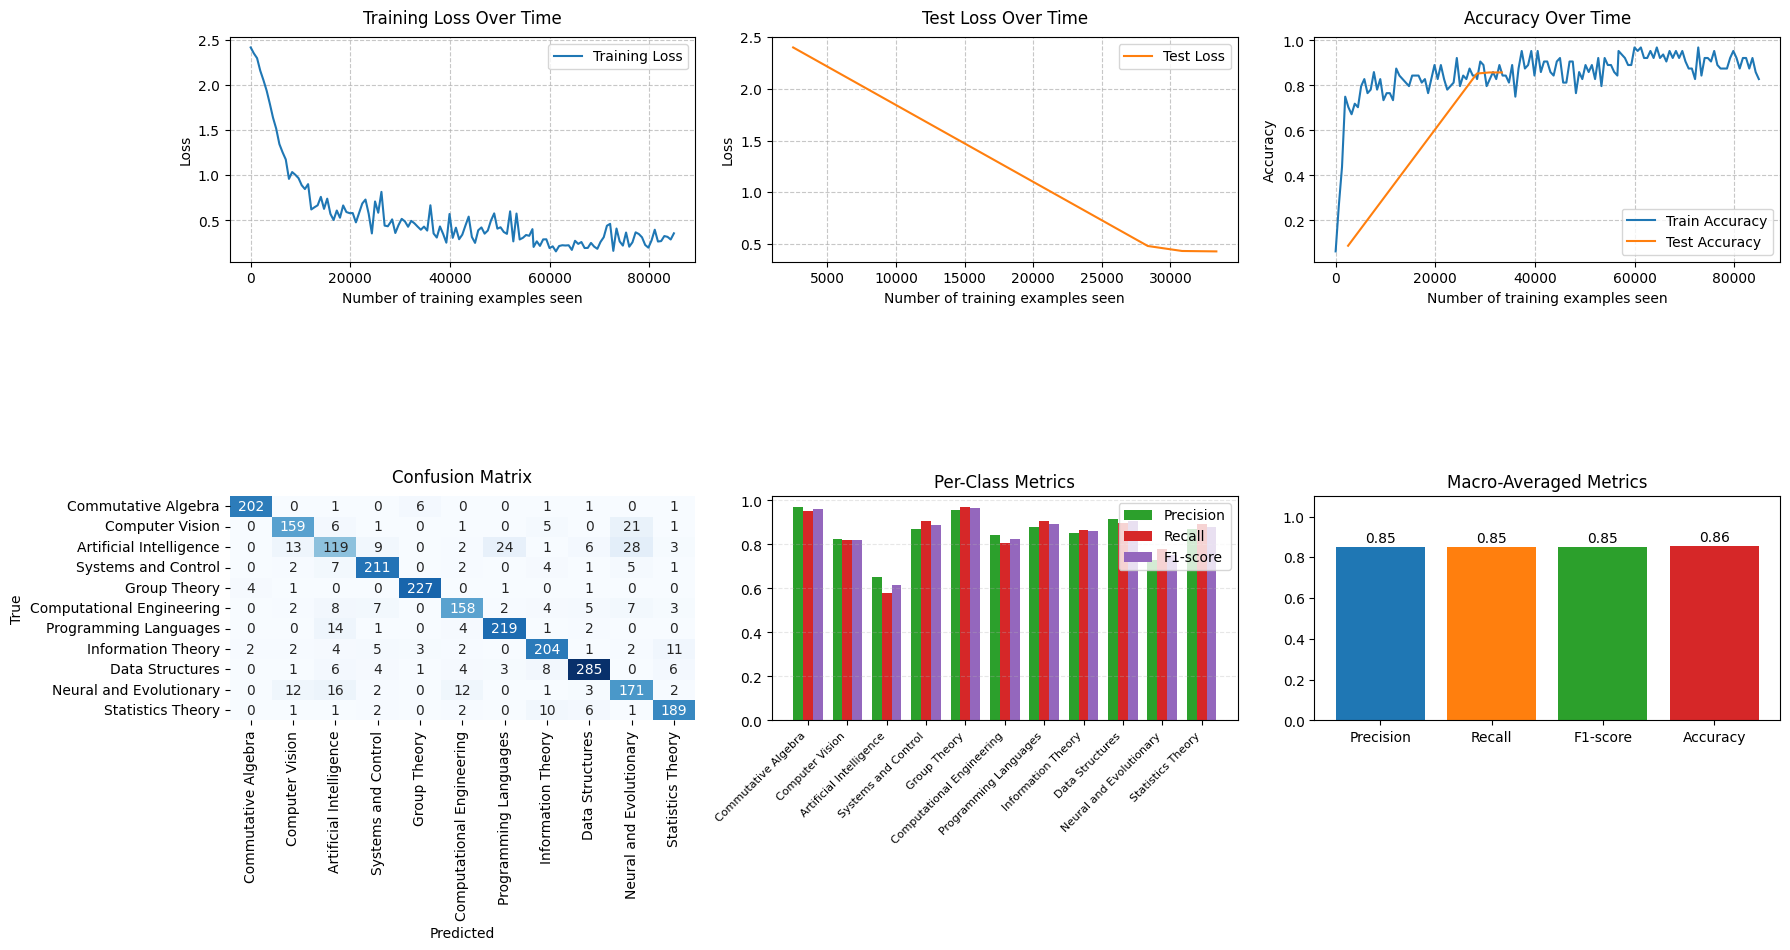


Detailed Classification Report:
                           precision    recall  f1-score   support

      Commutative Algebra       0.97      0.95      0.96       212
          Computer Vision       0.82      0.82      0.82       194
  Artificial Intelligence       0.65      0.58      0.61       205
      Systems and Control       0.87      0.91      0.89       233
             Group Theory       0.96      0.97      0.96       234
Computational Engineering       0.84      0.81      0.83       196
    Programming Languages       0.88      0.91      0.89       241
       Information Theory       0.85      0.86      0.86       236
          Data Structures       0.92      0.90      0.91       318
  Neural and Evolutionary       0.73      0.78      0.75       219
        Statistics Theory       0.87      0.89      0.88       212

                 accuracy                           0.86      2500
                macro avg       0.85      0.85      0.85      2500
             weighted avg  

In [220]:
plot_results(results_TFIDF_NN, class_names=list(arxiv_subjects.values()))

## Word2Vec

### Load the word2vec embeddings

In [221]:
# Load the Word2Vec embeddings
word2vec_embeddings_train = np.load("Word2Vec embeddings/word2vec_embedding.npz")["word2vec_embedding"]
print(f"Word2Vec embeddings shape: {word2vec_embeddings_train.shape}")

# Load the Word2Vec embeddings
word2vec_embeddings_test = np.load("Word2Vec embeddings/word2vec_embedding_test.npz")["word2vec_embedding_test"]
print(f"Word2Vec embeddings shape: {word2vec_embeddings_test.shape}")

Word2Vec embeddings shape: (28388, 300)
Word2Vec embeddings shape: (2500, 300)


### Linear Regression

In [ ]:
network_W2V = LogisticRegression(300)
results_W2V = train(
    network_W2V,
    epochs=10,
    data_train=word2vec_embeddings_train,
    data_test=word2vec_embeddings_test,
    labels_train=one_hot_labels_train,
    labels_test=one_hot_labels_test,
    log_interval=10,
    lr=0.001
)

Train Epoch: 1 [0/28388 (0%)]	Loss: 0.239761
Train Epoch: 1 [640/28388 (2%)]	Loss: 2.388672
Train Epoch: 1 [1280/28388 (5%)]	Loss: 2.373959
Train Epoch: 1 [1920/28388 (7%)]	Loss: 2.353911
Train Epoch: 1 [2560/28388 (9%)]	Loss: 2.343641
Train Epoch: 1 [3200/28388 (11%)]	Loss: 2.325538
Train Epoch: 1 [3840/28388 (14%)]	Loss: 2.300905
Train Epoch: 1 [4480/28388 (16%)]	Loss: 2.299432
Train Epoch: 1 [5120/28388 (18%)]	Loss: 2.273919
Train Epoch: 1 [5760/28388 (20%)]	Loss: 2.265763
Train Epoch: 1 [6400/28388 (23%)]	Loss: 2.263957
Train Epoch: 1 [7040/28388 (25%)]	Loss: 2.241206
Train Epoch: 1 [7680/28388 (27%)]	Loss: 2.223293
Train Epoch: 1 [8320/28388 (29%)]	Loss: 2.203341
Train Epoch: 1 [8960/28388 (32%)]	Loss: 2.198782
Train Epoch: 1 [9600/28388 (34%)]	Loss: 2.182666
Train Epoch: 1 [10240/28388 (36%)]	Loss: 2.177781
Train Epoch: 1 [10880/28388 (38%)]	Loss: 2.169857
Train Epoch: 1 [11520/28388 (41%)]	Loss: 2.136675
Train Epoch: 1 [12160/28388 (43%)]	Loss: 2.142708
Train Epoch: 1 [12800/283

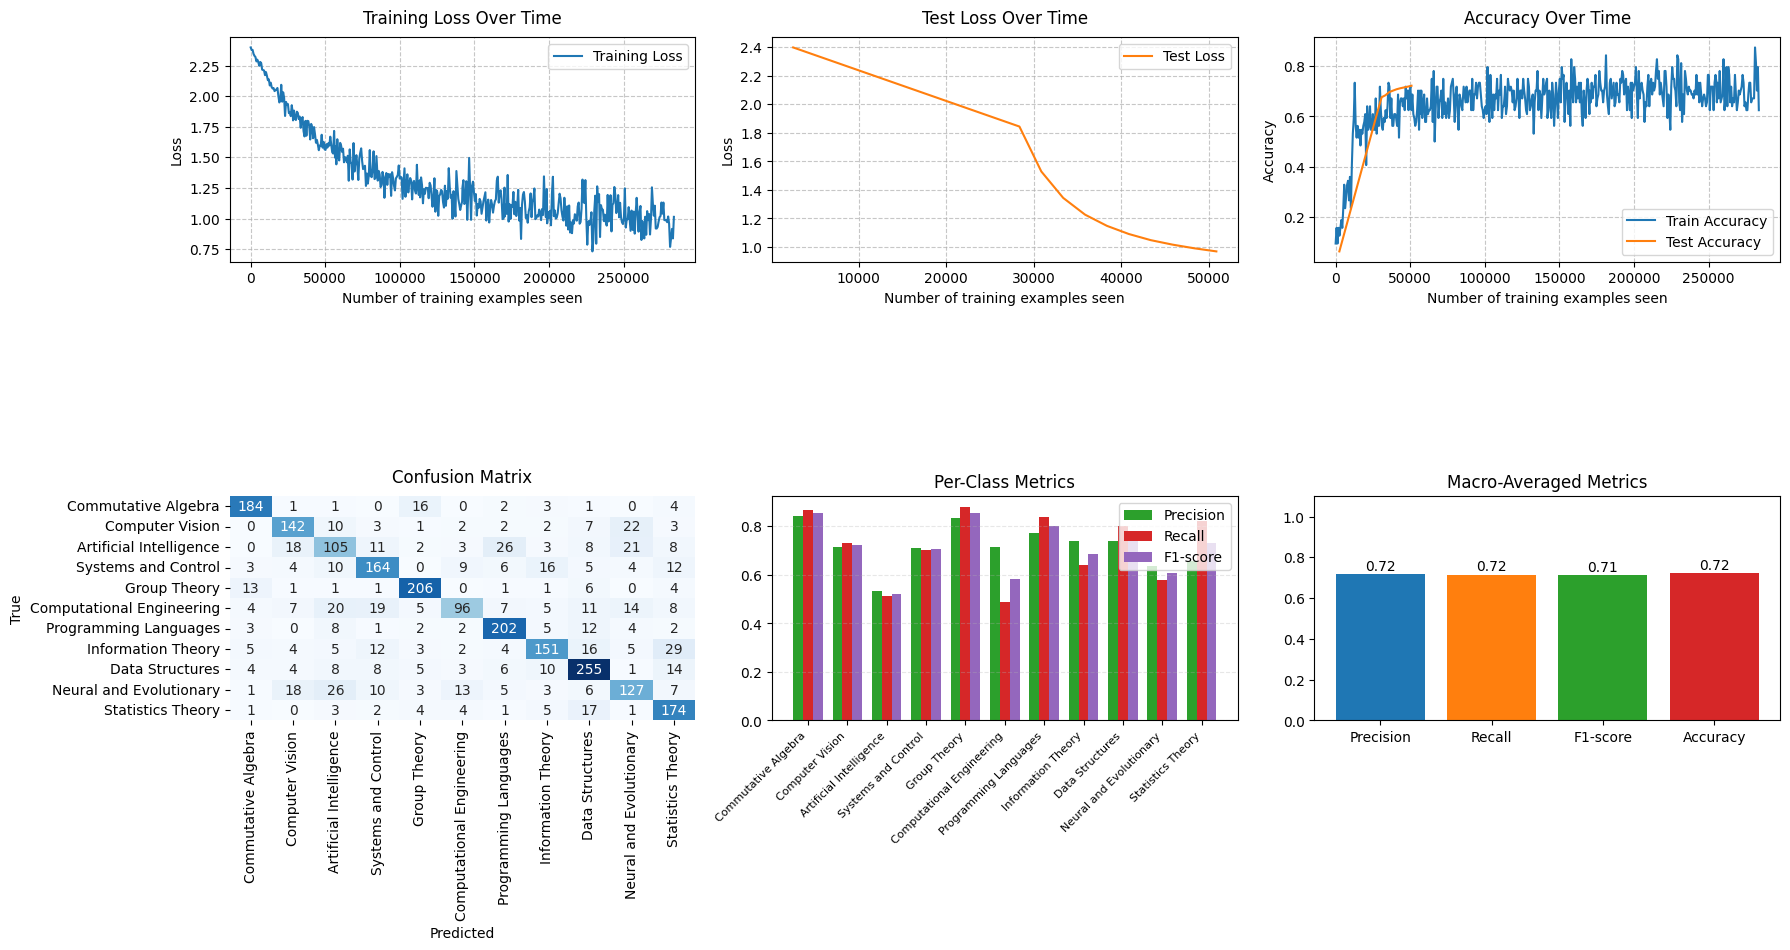


Detailed Classification Report:
                           precision    recall  f1-score   support

      Commutative Algebra       0.84      0.87      0.86       212
          Computer Vision       0.71      0.73      0.72       194
  Artificial Intelligence       0.53      0.51      0.52       205
      Systems and Control       0.71      0.70      0.71       233
             Group Theory       0.83      0.88      0.86       234
Computational Engineering       0.72      0.49      0.58       196
    Programming Languages       0.77      0.84      0.80       241
       Information Theory       0.74      0.64      0.69       236
          Data Structures       0.74      0.80      0.77       318
  Neural and Evolutionary       0.64      0.58      0.61       219
        Statistics Theory       0.66      0.82      0.73       212

                 accuracy                           0.72      2500
                macro avg       0.72      0.72      0.71      2500
             weighted avg  

In [224]:
plot_results(results_W2V, class_names=list(arxiv_subjects.values()))

### MLP

In [ ]:
network_W2V_NN = NN(300)
results_W2V_NN = train(
    network_W2V_NN,
    epochs=10,
    data_train=word2vec_embeddings_train,
    data_test=word2vec_embeddings_test,
    labels_train=one_hot_labels_train,
    labels_test=one_hot_labels_test,
    log_interval=10,
    lr=0.001
)


Train Epoch: 1 [0/28388 (0%)]	Loss: 0.239153
Train Epoch: 1 [640/28388 (2%)]	Loss: 2.389677
Train Epoch: 1 [1280/28388 (5%)]	Loss: 2.377885
Train Epoch: 1 [1920/28388 (7%)]	Loss: 2.365240
Train Epoch: 1 [2560/28388 (9%)]	Loss: 2.341290
Train Epoch: 1 [3200/28388 (11%)]	Loss: 2.329885
Train Epoch: 1 [3840/28388 (14%)]	Loss: 2.308366
Train Epoch: 1 [4480/28388 (16%)]	Loss: 2.279520
Train Epoch: 1 [5120/28388 (18%)]	Loss: 2.252275
Train Epoch: 1 [5760/28388 (20%)]	Loss: 2.221329
Train Epoch: 1 [6400/28388 (23%)]	Loss: 2.193257
Train Epoch: 1 [7040/28388 (25%)]	Loss: 2.148120
Train Epoch: 1 [7680/28388 (27%)]	Loss: 2.094678
Train Epoch: 1 [8320/28388 (29%)]	Loss: 2.055143
Train Epoch: 1 [8960/28388 (32%)]	Loss: 2.026800
Train Epoch: 1 [9600/28388 (34%)]	Loss: 1.959605
Train Epoch: 1 [10240/28388 (36%)]	Loss: 1.906344
Train Epoch: 1 [10880/28388 (38%)]	Loss: 1.880996
Train Epoch: 1 [11520/28388 (41%)]	Loss: 1.832763
Train Epoch: 1 [12160/28388 (43%)]	Loss: 1.795937
Train Epoch: 1 [12800/283

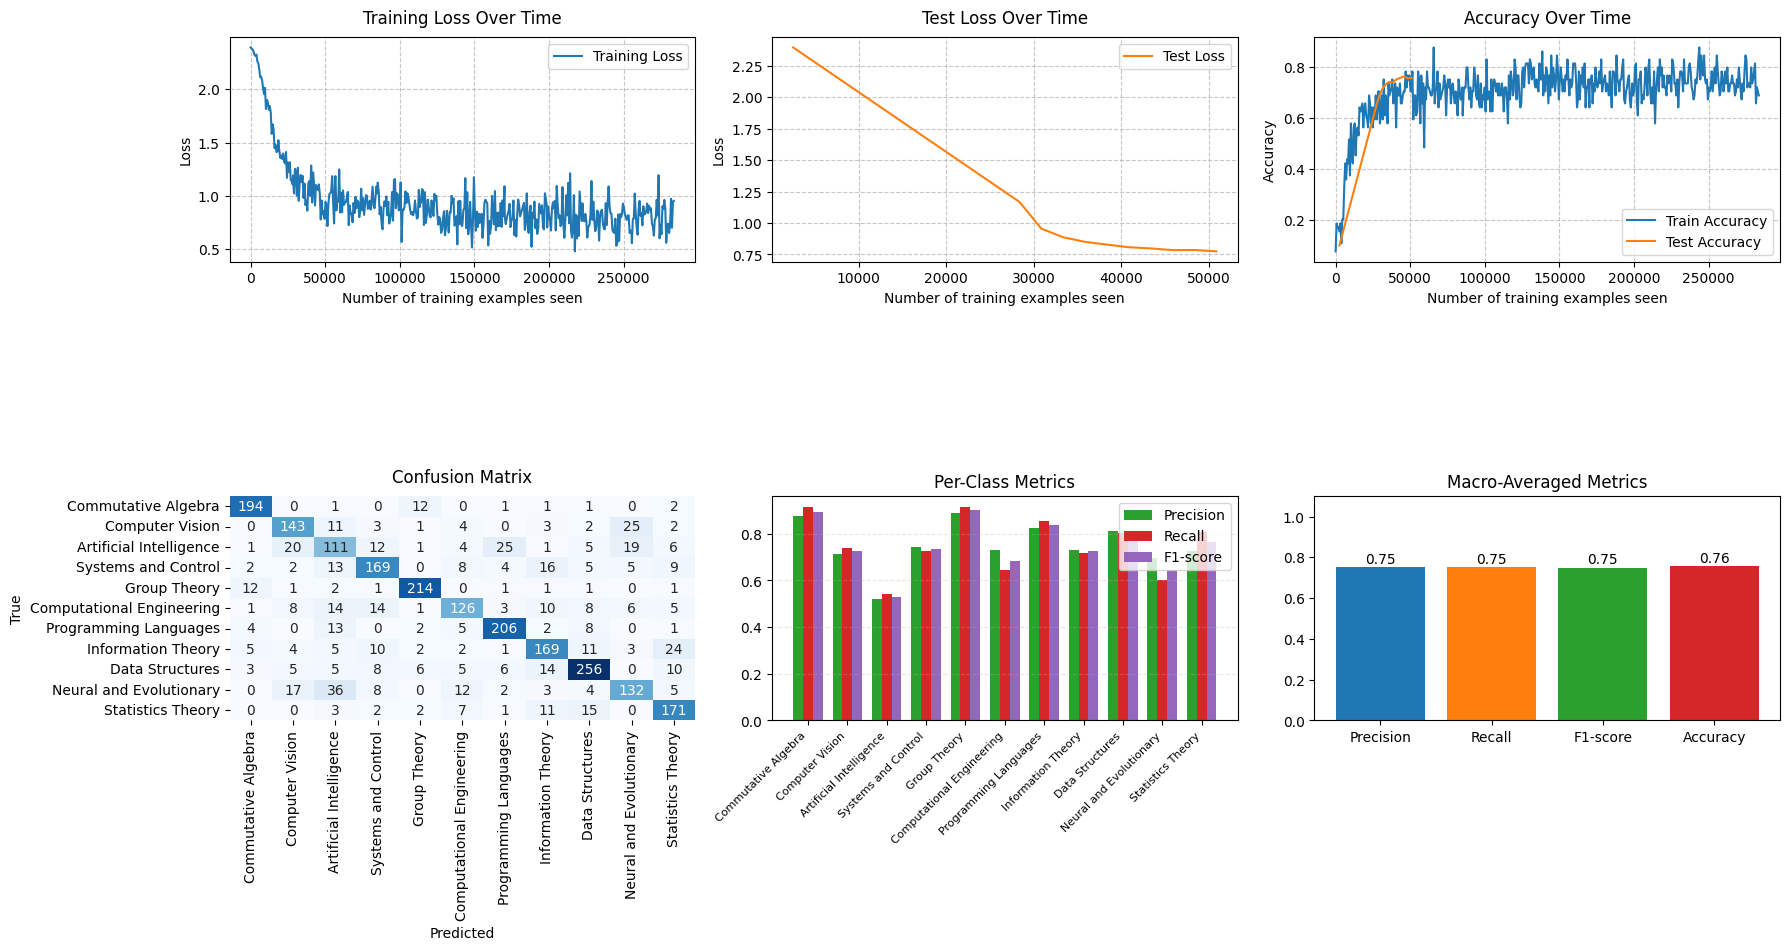


Detailed Classification Report:
                           precision    recall  f1-score   support

      Commutative Algebra       0.87      0.92      0.89       212
          Computer Vision       0.71      0.74      0.73       194
  Artificial Intelligence       0.52      0.54      0.53       205
      Systems and Control       0.74      0.73      0.73       233
             Group Theory       0.89      0.91      0.90       234
Computational Engineering       0.73      0.64      0.68       196
    Programming Languages       0.82      0.85      0.84       241
       Information Theory       0.73      0.72      0.72       236
          Data Structures       0.81      0.81      0.81       318
  Neural and Evolutionary       0.69      0.60      0.65       219
        Statistics Theory       0.72      0.81      0.76       212

                 accuracy                           0.76      2500
                macro avg       0.75      0.75      0.75      2500
             weighted avg  

In [226]:
plot_results(results_W2V_NN, class_names=list(arxiv_subjects.values()))